<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingHouseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curling Neural Network (Convolutional)

Since we're working with annotated images with 3 channels (RGB) it makes the most sense to use a 2D convolutional network. This will reduce the number of parameters and greatly increase performance, we can also keep our image coloring though I imagine this may not stick, since colored images require us to train on a 3D tensor (3 color channels) while a grayscale allows us to efficiently perform in 1 channel only, so we can operate in 2 dimensions instead of 3, which will yield quicker model results, though sometimes less accurate.

All models will be trained on an NVIDIA Tesla V100 Tensor Core GPU with 32 GB of VRAM

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f4918c38556c4236ac2c8d393f557226eb98f4eda8dd00f5cf5347db6df6bd77
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Here's my first attempt at a Convolutional Neural Network:

In [2]:
import os
import torch
import pandas as pd
from torchviz import make_dot
from google.colab import drive
from IPython.display import Image
from matplotlib import pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Pulling in the Dataset (importing on Colab is a massive pain):

In [4]:
class CurlingDataset(Dataset):

  _train = None
  _test = None
  _validate = None

  def __init__(self, csv_loc, img_dir, set_type="train", transform=None, target_transform=None):
    self.data = pd.read_csv(csv_loc)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform


    if type(CurlingDataset._train) == type(None):
      print("Performing a split")
      CurlingDataset._train, CurlingDataset._test, CurlingDataset._validate = self.__split()

    self.data = CurlingDataset._train if set_type == "train" else (CurlingDataset._test if set_type == "test" else CurlingDataset._validate)

  def __len__(self):
    return len(self.data)

  def __split(self):

    train, test = train_test_split(self.data, train_size=.70, stratify=self.data['empty'])
    test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])

    return train, test, validate

  def __getitem__(self, index):

    img_path = os.path.join(self.img_dir, self.data.iloc[index, 1])

    image = read_image(img_path)
    label = torch.tensor(int(self.data.iloc[index, 2]))

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [5]:
train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="train",
    transform=transforms.Resize((512, 512))
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="test",
    transform=transforms.Resize((512, 512))
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="validate",
    transform=transforms.Resize((512, 512))
)

Performing a split


In [6]:
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)
validate_dataloader = DataLoader(validate_data, batch_size=32)

## The Model

This is a simple convulational neural network. I'm starting off with the following convulational stack:


```
    self.conv_stack = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, 3, stride=1, padding=1),  <- Input Layer
        torch.nn.ReLU(),
        torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 32, 3, stride=1, padding=1), <- Hidden Layer
        torch.nn.ReLU()
    )
```

and a second Fully Connected stack:

```
    self.fc_stack = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 512 * 512, 128), <- Input Layer (technically hidden)
        torch.nn.ReLU(),
        torch.nn.Linear(128, 128), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Linear(64, 2) <- Output Layer
    )
```


The idea here is that the convolutional network can make better inferences on an image than a classic Fully Connected Neural Net, but it is not very good at making classifications, hence why we connect the output of the Convolutional Layer to the Fully Connected Neural Network (FCNN). The goal is that the complex inferences made by the CNN can allow us to train a good enough classifier on the FCNN to interpret the results to 0 or 1. Technically speaking, this is a pipeline and not just one network...

In [7]:
class CurlingClassifierCNN(torch.nn.Module):
  def __init__(self):
    super(CurlingClassifierCNN, self).__init__()
    self.conv_stack = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, 3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(16, 32, 3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 32, 3, stride=1, padding=1),
        torch.nn.ReLU()
    )

    self.fc_stack = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 512 * 512, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 2)
    )

  def forward(self, x):
    logits = self.fc_stack(self.conv_stack(x))
    return logits

Switch to the V100 GPU to speed things up:

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Get some model info about how many parameters we have:

In [9]:
model = CurlingClassifierCNN().to(device)

print(model)
print("\nOur Model's Layers (as Tensors):")
for param in model.parameters():
  print(param.size())

CurlingClassifierCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8388608, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
)

Our Model's Layers (as Tensors):
torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([128, 8388608])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([2,

In [14]:
test_input = torch.rand(32, 3, 512, 512).to(device)
logits = model.forward(test_input)
print(logits.size())

torch.Size([32, 2])


Now that we know the model is set up correctly, let's plot a diagram. The initial model is very hefty and maybe a bit overkill, so I may come back and add some Max Pooling layers to the CNN so that we are reading a reduced amount of data is this seems to be too much to train. The code cell below will help visualize the Network to help debug if needed so that we can see all Neurons and biases.

NOTE: This cell will save an image to your filesystem, this is so my Colab runtime will properly render the whole image to just the cell since torchviz won't take that into account when displaying.

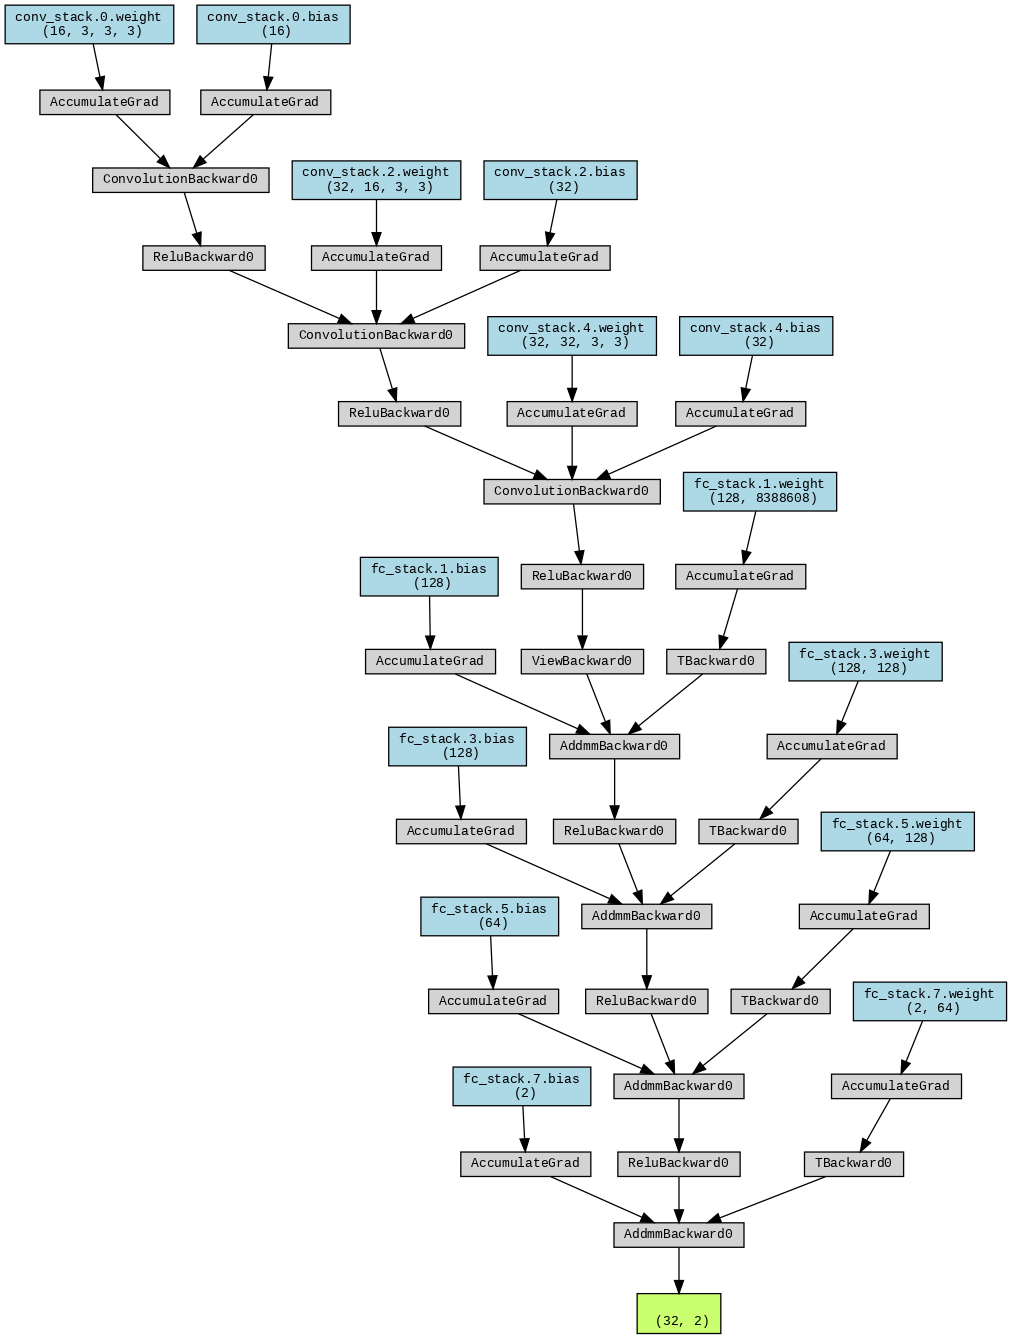

In [15]:
dot = make_dot(logits, params=dict(list(model.named_parameters()) + [('x', test_input)]))
dot.render('network_visualization', format='png')
Image('network_visualization.png')

#### Loss Function: Cross Entropy Loss

We'll be starting with a Cross Entropy Loss (CEL) function as for our purposes a standard Loss function should do the trick, and CEL tends to produce a faster rate of convergence and have a steeper gradient than other loss functions. Basically, it's good for our purposes and fast

#### Optimizer: Stochastic Gradient Descent

I'm hoping Stochastic Gradient Descent is enough for this, though I might switch to Adam. The main difference is that SGD has a static learning rate while Adam dynamically adjusts its learning rate during training. Overall, I'm open to the switch, but let's start with a static learning rate.

In [16]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)